<a href="https://colab.research.google.com/github/zdanielshi/data_science_LFZ/blob/main/DS_0615_KC_house_prices_transformations%2C_encoding%2C_scaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [822]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [823]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
pd.set_option('display.float_format', lambda x: '%.5f' % x)
from scipy import stats
from scipy.special import inv_boxcox
from sklearn.preprocessing import RobustScaler, MinMaxScaler, MaxAbsScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [824]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [825]:
kc = pd.read_csv('/content/kc_house_data.csv')

# High level analysis and observations

In [826]:
kc

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.00000,3,1.00000,1180,5650,1.00000,0,0,...,7,1180,0,1955,0,98178,47.51120,-122.25700,1340,5650
1,6414100192,20141209T000000,538000.00000,3,2.25000,2570,7242,2.00000,0,0,...,7,2170,400,1951,1991,98125,47.72100,-122.31900,1690,7639
2,5631500400,20150225T000000,180000.00000,2,1.00000,770,10000,1.00000,0,0,...,6,770,0,1933,0,98028,47.73790,-122.23300,2720,8062
3,2487200875,20141209T000000,604000.00000,4,3.00000,1960,5000,1.00000,0,0,...,7,1050,910,1965,0,98136,47.52080,-122.39300,1360,5000
4,1954400510,20150218T000000,510000.00000,3,2.00000,1680,8080,1.00000,0,0,...,8,1680,0,1987,0,98074,47.61680,-122.04500,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.00000,3,2.50000,1530,1131,3.00000,0,0,...,8,1530,0,2009,0,98103,47.69930,-122.34600,1530,1509
21609,6600060120,20150223T000000,400000.00000,4,2.50000,2310,5813,2.00000,0,0,...,8,2310,0,2014,0,98146,47.51070,-122.36200,1830,7200
21610,1523300141,20140623T000000,402101.00000,2,0.75000,1020,1350,2.00000,0,0,...,7,1020,0,2009,0,98144,47.59440,-122.29900,1020,2007
21611,291310100,20150116T000000,400000.00000,3,2.50000,1600,2388,2.00000,0,0,...,8,1600,0,2004,0,98027,47.53450,-122.06900,1410,1287


In [827]:
# simple clean up - update the date field to be date format
kc.date = pd.to_datetime(kc.date)

In [828]:
kc.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.00000,3,1.00000,1180,5650,1.00000,0,0,...,7,1180,0,1955,0,98178,47.51120,-122.25700,1340,5650
1,6414100192,2014-12-09,538000.00000,3,2.25000,2570,7242,2.00000,0,0,...,7,2170,400,1951,1991,98125,47.72100,-122.31900,1690,7639
2,5631500400,2015-02-25,180000.00000,2,1.00000,770,10000,1.00000,0,0,...,6,770,0,1933,0,98028,47.73790,-122.23300,2720,8062
3,2487200875,2014-12-09,604000.00000,4,3.00000,1960,5000,1.00000,0,0,...,7,1050,910,1965,0,98136,47.52080,-122.39300,1360,5000
4,1954400510,2015-02-18,510000.00000,3,2.00000,1680,8080,1.00000,0,0,...,8,1680,0,1987,0,98074,47.61680,-122.04500,1800,7503


In [829]:
kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21613 non-null  int64         
 1   date           21613 non-null  datetime64[ns]
 2   price          21613 non-null  float64       
 3   bedrooms       21613 non-null  int64         
 4   bathrooms      21613 non-null  float64       
 5   sqft_living    21613 non-null  int64         
 6   sqft_lot       21613 non-null  int64         
 7   floors         21613 non-null  float64       
 8   waterfront     21613 non-null  int64         
 9   view           21613 non-null  int64         
 10  condition      21613 non-null  int64         
 11  grade          21613 non-null  int64         
 12  sqft_above     21613 non-null  int64         
 13  sqft_basement  21613 non-null  int64         
 14  yr_built       21613 non-null  int64         
 15  yr_renovated   2161

In [830]:
kc.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000
mean,4580301520.86499,540088.14177,3.37084,2.11476,2079.89974,15106.96757,1.49431,0.00754,0.23430,3.40943,7.65687,1788.39069,291.50905,1971.00514,84.40226,98077.93980,47.56005,-122.21390,1986.55249,12768.45565
std,2876565571.31206,367127.19648,0.93006,0.77016,918.44090,41420.51152,0.53999,0.08652,0.76632,0.65074,1.17546,828.09098,442.57504,29.37341,401.67924,53.50503,0.13856,0.14083,685.39130,27304.17963
min,1000102.00000,75000.00000,0.00000,0.00000,290.00000,520.00000,1.00000,0.00000,0.00000,1.00000,1.00000,290.00000,0.00000,1900.00000,0.00000,98001.00000,47.15590,-122.51900,399.00000,651.00000
25%,2123049194.00000,321950.00000,3.00000,1.75000,1427.00000,5040.00000,1.00000,0.00000,0.00000,3.00000,7.00000,1190.00000,0.00000,1951.00000,0.00000,98033.00000,47.47100,-122.32800,1490.00000,5100.00000
50%,3904930410.00000,450000.00000,3.00000,2.25000,1910.00000,7618.00000,1.50000,0.00000,0.00000,3.00000,7.00000,1560.00000,0.00000,1975.00000,0.00000,98065.00000,47.57180,-122.23000,1840.00000,7620.00000
75%,7308900445.00000,645000.00000,4.00000,2.50000,2550.00000,10688.00000,2.00000,0.00000,0.00000,4.00000,8.00000,2210.00000,560.00000,1997.00000,0.00000,98118.00000,47.67800,-122.12500,2360.00000,10083.00000
max,9900000190.00000,7700000.00000,33.00000,8.00000,13540.00000,1651359.00000,3.50000,1.00000,4.00000,5.00000,13.00000,9410.00000,4820.00000,2015.00000,2015.00000,98199.00000,47.77760,-121.31500,6210.00000,871200.00000


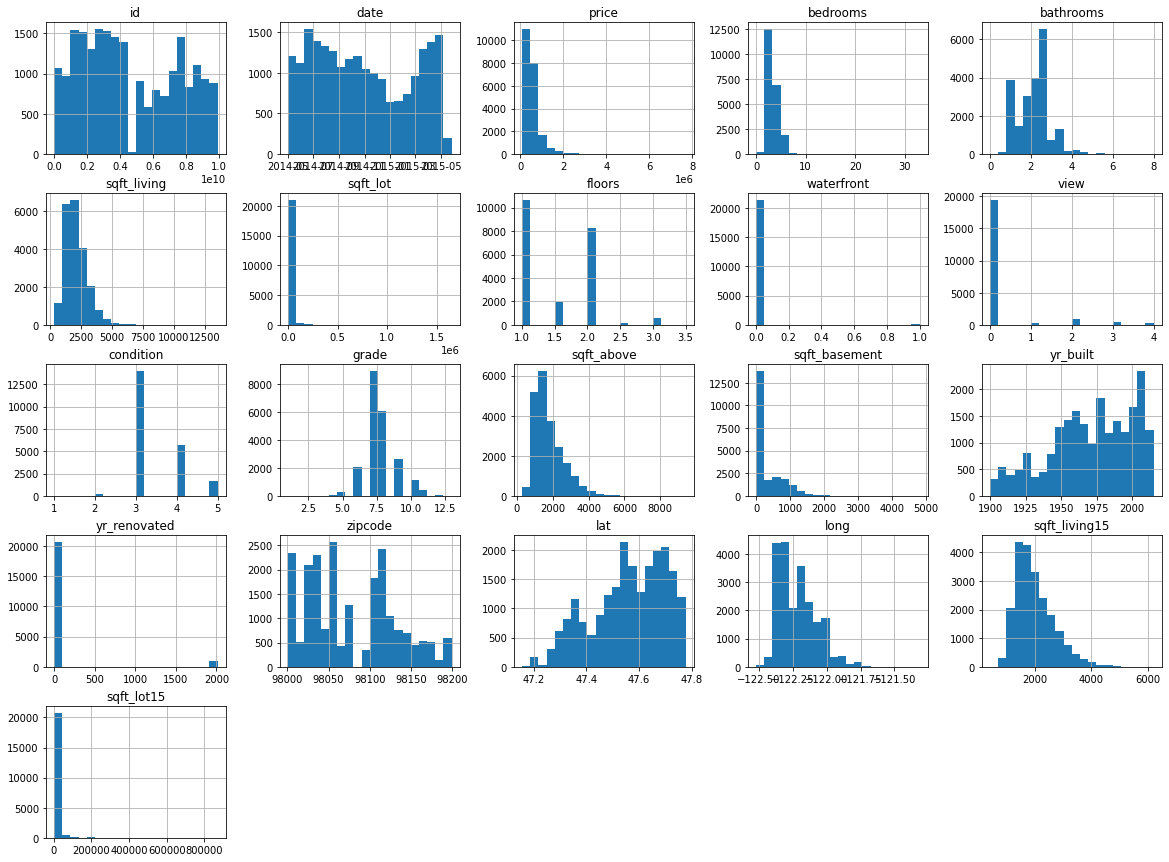

In [831]:
kc.hist(figsize =(20,15), bins = 20);

In [832]:
#sns.pairplot(kc)

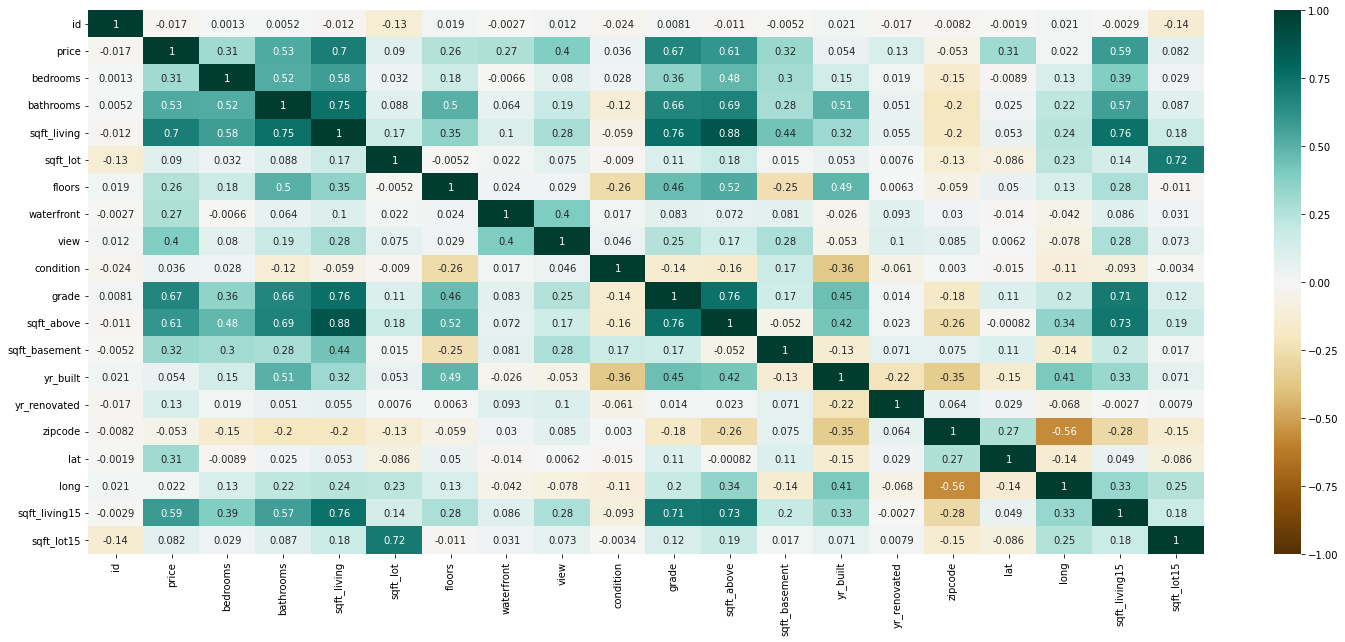

In [833]:
plt.figure(figsize=(25,10))
heatmap = sns.heatmap(kc.corr(),vmin=-1, vmax=1, annot=True, cmap = 'BrBG')

## Observations about the data
* Date probbaly needs to be cleaned up
* No null values
* year built needs to be cleaned up?
* yr renovated needs to be cleaned up?
  * 0 years should be NaN

Outliers
* Number of bedrooms
* Price
* Basement square feet
* Lot square feet
* long and lat

Deep dive:
* Waterfront - nothing 
* year built - nothing
* year renovated - nothing
* bedrooms - 
* bathrooms

Things to clean up:
* Bedroom outliers - the 33 is a fat finger. The other values are harder to tell
* Bathroom outliers
* Over $1M houses with zero beds and zero baths, needs to be cleaned up.

Features to add:
* Ratio of square feet to neighbors square feet for lot and living
* Price per square feet for living
* Price per square feet for lot

# Deep dives

### sqft vs sqft15

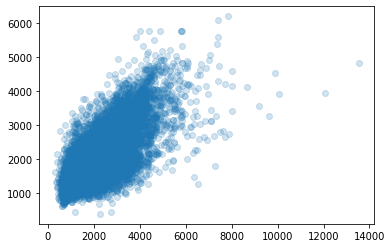

In [834]:
plt.scatter(kc.sqft_living, kc.sqft_living15, alpha = 0.2)

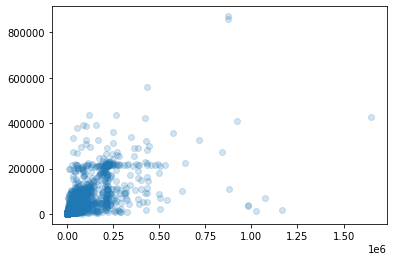

In [835]:
plt.scatter(kc.sqft_lot, kc.sqft_lot15, alpha = 0.2)

## Water front

In [836]:
kc.waterfront.value_counts()

0    21450
1      163
Name: waterfront, dtype: int64

## Year built

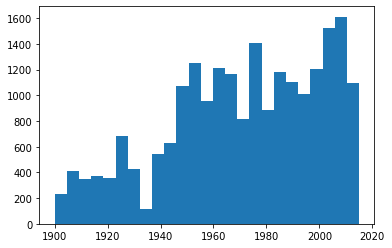

In [837]:
plt.hist(kc.yr_built, bins = 25);

In [838]:
kc.yr_built.value_counts()

2014    559
2006    454
2005    450
2004    433
2003    422
       ... 
1933     30
1901     29
1902     27
1935     24
1934     21
Name: yr_built, Length: 116, dtype: int64

## Year renovated

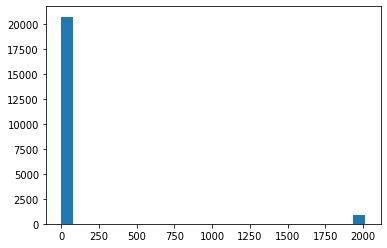

In [839]:
plt.hist(kc.yr_renovated, bins = 25);

In [840]:
kc.yr_renovated.value_counts()

0       20699
2014       91
2013       37
2003       36
2005       35
        ...  
1951        1
1959        1
1948        1
1954        1
1944        1
Name: yr_renovated, Length: 70, dtype: int64

## Bedrooms
* There is one clear outlier with 33 bedrooms, which should be 3 bedrooms.
* There are some houses listed with 11 bedrooms, but they look plausible, although extreme. They may be houses for college students that have been subdivided into a lot of rooms. 


### Bedrooms analysis

In [841]:
kc.bedrooms.value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      199
7       38
0       13
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

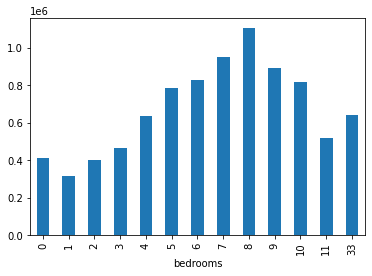

In [842]:
kc.groupby('bedrooms')['price'].mean().plot(kind = 'bar');

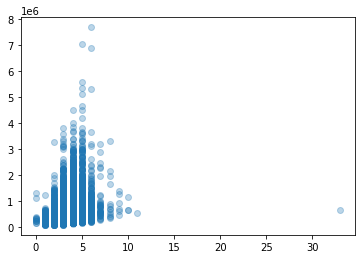

In [843]:
plt.scatter(kc.bedrooms,kc.price, alpha = 0.3);

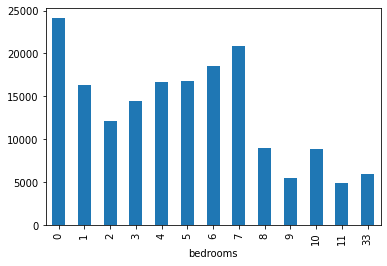

In [844]:
kc.groupby('bedrooms')['sqft_lot'].mean().plot(kind = 'bar');

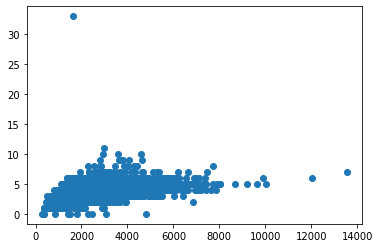

In [845]:
plt.scatter(kc.sqft_living, kc.bedrooms);

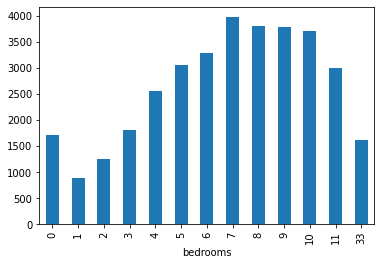

In [846]:
kc.groupby('bedrooms')['sqft_living'].mean().plot(kind = 'bar');

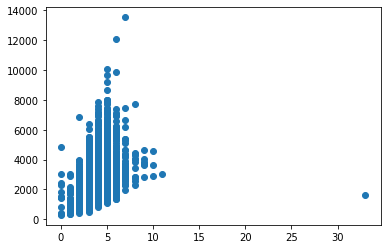

In [847]:
plt.scatter(kc.bedrooms,kc.sqft_living);

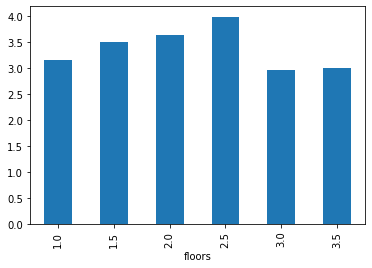

In [848]:
kc.groupby('floors')['bedrooms'].mean().plot(kind = 'bar');

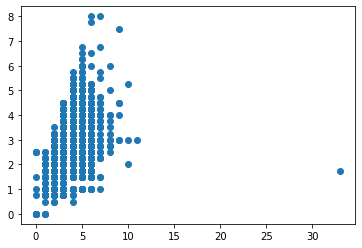

In [849]:
plt.scatter(kc.bedrooms,kc.bathrooms);

### Look at houses with A LOT of bedrooms





In [850]:
many_beds = kc[kc.bedrooms >= 10]
many_beds

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8757,1773100755,2014-08-21,520000.00000,11,3.00000,3000,4960,2.00000,0,0,...,7,2400,600,1918,1999,98106,47.55600,-122.36300,1420,4960
13314,627300145,2014-08-14,1148000.00000,10,5.25000,4590,10920,1.00000,0,2,...,9,2500,2090,2008,0,98004,47.58610,-122.11300,2730,10400
15161,5566100170,2014-10-29,650000.00000,10,2.00000,3610,11914,2.00000,0,0,...,7,3010,600,1958,0,98006,47.57050,-122.17500,2040,11914
15870,2402100895,2014-06-25,640000.00000,33,1.75000,1620,6000,1.00000,0,0,...,7,1040,580,1947,0,98103,47.68780,-122.33100,1330,4700
19254,8812401450,2014-12-29,660000.00000,10,3.00000,2920,3745,2.00000,0,0,...,7,1860,1060,1913,0,98105,47.66350,-122.32000,1810,3745


There is one very old house with 11 bedrooms. But it has 3000 square feet and was built in 1918. Maybe it was turned into a college student housing building

### Look at houses with zero bedrooms

In [851]:
zero_beds = kc[kc.bedrooms == 0]

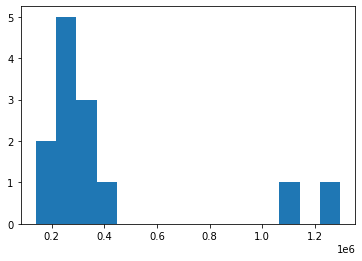

In [852]:
plt.hist(zero_beds.price, bins = 15);

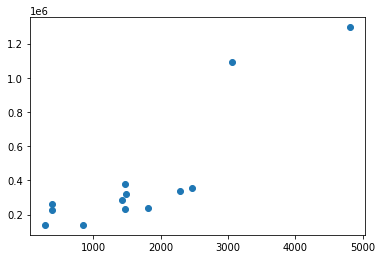

In [853]:
plt.scatter(zero_beds.sqft_living, zero_beds.price)

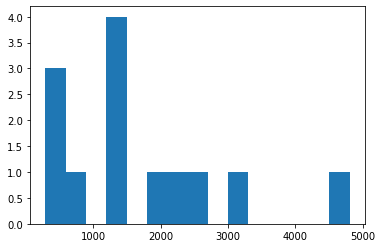

In [854]:
plt.hist(zero_beds.sqft_living, bins = 15);

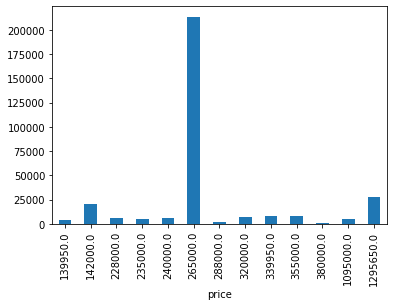

In [855]:
zero_beds.groupby('price')['sqft_lot'].median().plot(kind='bar')

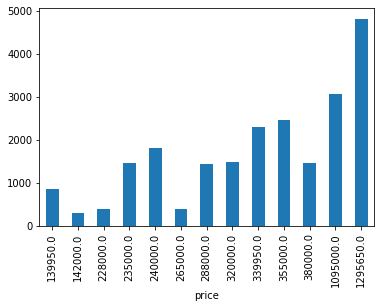

In [856]:
zero_beds.groupby('price')['sqft_living'].mean().plot(kind='bar')

In [857]:
zero_beds[zero_beds['price'] > 1000000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
875,6306400140,2014-06-12,1095000.00000,0,0.00000,3064,4764,3.50000,0,2,...,7,3064,0,1990,0,98102,47.63620,-122.32200,2360,4000
6994,2954400190,2014-06-24,1295650.00000,0,0.00000,4810,28008,2.00000,0,0,...,12,4810,0,1990,0,98053,47.66420,-122.06900,4740,35061


How many bedrooms and baths do the average $1M home have?

In [858]:
mil_house = kc[kc.price.between(975000,1250000)]

In [859]:
mil_house.bedrooms.value_counts()

4     382
3     192
5     133
6      24
2      20
7       3
0       1
1       1
10      1
Name: bedrooms, dtype: int64

## Bathrooms

### Analysis

In [860]:
kc.bathrooms.value_counts()

2.50000    5380
1.00000    3852
1.75000    3048
2.25000    2047
2.00000    1930
1.50000    1446
2.75000    1185
3.00000     753
3.50000     731
3.25000     589
3.75000     155
4.00000     136
4.50000     100
4.25000      79
0.75000      72
4.75000      23
5.00000      21
5.25000      13
0.00000      10
5.50000      10
1.25000       9
6.00000       6
0.50000       4
5.75000       4
6.75000       2
8.00000       2
6.25000       2
6.50000       2
7.50000       1
7.75000       1
Name: bathrooms, dtype: int64

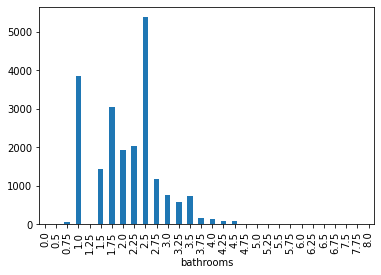

In [861]:
kc.groupby('bathrooms')['bedrooms'].count().plot(kind='bar');

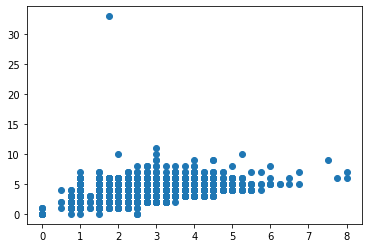

In [862]:
plt.scatter(kc.bathrooms, kc.bedrooms);

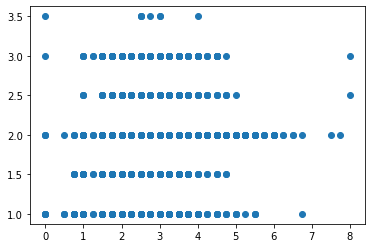

In [863]:
plt.scatter(kc.bathrooms, kc.floors)

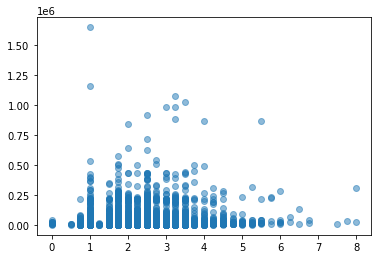

In [864]:
plt.scatter(kc.bathrooms, kc.sqft_lot, alpha = 0.5)

#### What's going on with the houses with a lot of bathrooms?

While these have a lot of bathrooms, they do seem to align with the size of the houses as well as the # of bedrooms.

In [865]:
many_baths = kc[kc.bathrooms > 7]
many_baths

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7252,6762700020,2014-10-13,7700000.00000,6,8.00000,12050,27600,2.50000,0,3,...,13,8570,3480,1910,1987,98102,47.62980,-122.32300,3940,8800
8546,424049043,2014-08-11,450000.00000,9,7.50000,4050,6504,2.00000,0,0,...,7,4050,0,1996,0,98144,47.59230,-122.30100,1448,3866
9254,9208900037,2014-09-19,6885000.00000,6,7.75000,9890,31374,2.00000,0,4,...,13,8860,1030,2001,0,98039,47.63050,-122.24000,4540,42730
12777,1225069038,2014-05-05,2280000.00000,7,8.00000,13540,307752,3.00000,0,4,...,12,9410,4130,1999,0,98053,47.66750,-121.98600,4850,217800


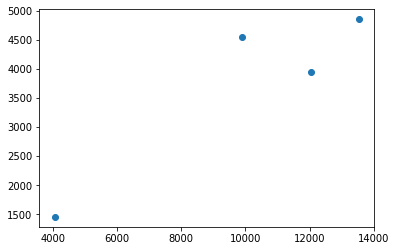

In [866]:
plt.scatter(many_baths.sqft_living, many_baths.sqft_living15)

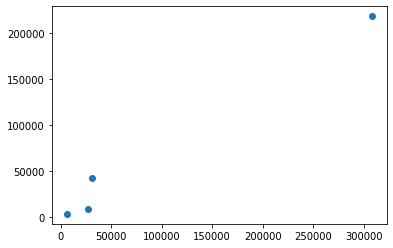

In [867]:
plt.scatter(many_baths.sqft_lot, many_baths.sqft_lot15)

#### What's going on with the houses with zero bathrooms
* It is possible to have a house with less than "1" bathroom. Those could be half or 3/4 baths.

In [868]:
zero_baths = kc[kc.bathrooms < 0.5]
zero_baths

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
875,6306400140,2014-06-12,1095000.00000,0,0.00000,3064,4764,3.50000,0,2,...,7,3064,0,1990,0,98102,47.63620,-122.32200,2360,4000
1149,3421079032,2015-02-17,75000.00000,1,0.00000,670,43377,1.00000,0,0,...,3,670,0,1966,0,98022,47.26380,-121.90600,1160,42882
3119,3918400017,2015-02-05,380000.00000,0,0.00000,1470,979,3.00000,0,2,...,8,1470,0,2006,0,98133,47.71450,-122.35600,1470,1399
5832,5702500050,2014-11-04,280000.00000,1,0.00000,600,24501,1.00000,0,0,...,3,600,0,1950,0,98045,47.53160,-121.74900,990,22549
6994,2954400190,2014-06-24,1295650.00000,0,0.00000,4810,28008,2.00000,0,0,...,12,4810,0,1990,0,98053,47.66420,-122.06900,4740,35061
9773,3374500520,2015-04-29,355000.00000,0,0.00000,2460,8049,2.00000,0,0,...,8,2460,0,1990,0,98031,47.40950,-122.16800,2520,8050
9854,7849202190,2014-12-23,235000.00000,0,0.00000,1470,4800,2.00000,0,0,...,7,1470,0,1996,0,98065,47.52650,-121.82800,1060,7200
10481,203100435,2014-09-18,484000.00000,1,0.00000,690,23244,1.00000,0,0,...,7,690,0,1948,0,98053,47.64290,-121.95500,1690,19290
14423,9543000205,2015-04-13,139950.00000,0,0.00000,844,4269,1.00000,0,0,...,7,844,0,1913,0,98001,47.27810,-122.25000,1380,9600
19452,3980300371,2014-09-26,142000.00000,0,0.00000,290,20875,1.00000,0,0,...,1,290,0,1963,0,98024,47.53080,-121.88800,1620,22850


In [869]:
mil_house.bathrooms.value_counts()

2.50000    178
3.50000     99
3.25000     84
2.75000     76
2.25000     76
3.00000     59
3.75000     35
1.75000     34
4.00000     27
2.00000     22
4.50000     17
4.25000     15
1.50000     14
1.00000     10
5.00000      3
4.75000      2
5.25000      2
0.00000      1
1.25000      1
5.50000      1
6.50000      1
Name: bathrooms, dtype: int64

In [870]:
mil_house.bathrooms.median()

2.75

# Clean up
* Clean up the bedroom outlier
* For renovated year: make the zero year values changed to NaN
* Over $1M homes, have 4 bedrooms and 2.75 baths.
* Fixing the zero values for years renovated.

In [871]:
# Clean up the 33 bedrooms outlier
kc[kc.bedrooms > 10]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8757,1773100755,2014-08-21,520000.00000,11,3.00000,3000,4960,2.00000,0,0,...,7,2400,600,1918,1999,98106,47.55600,-122.36300,1420,4960
15870,2402100895,2014-06-25,640000.00000,33,1.75000,1620,6000,1.00000,0,0,...,7,1040,580,1947,0,98103,47.68780,-122.33100,1330,4700


In [872]:
kc.bedrooms = kc.bedrooms.apply(lambda x: 3 if x == 33 else x)

In [873]:
kc[kc.bedrooms > 10]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8757,1773100755,2014-08-21,520000.00000,11,3.00000,3000,4960,2.00000,0,0,...,7,2400,600,1918,1999,98106,47.55600,-122.36300,1420,4960


In [874]:
# >$1M homes with zero bedrooms, make it 4 beds

In [875]:
kc[(kc.price > 1000000) & (kc.bedrooms == 0)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
875,6306400140,2014-06-12,1095000.00000,0,0.00000,3064,4764,3.50000,0,2,...,7,3064,0,1990,0,98102,47.63620,-122.32200,2360,4000
6994,2954400190,2014-06-24,1295650.00000,0,0.00000,4810,28008,2.00000,0,0,...,12,4810,0,1990,0,98053,47.66420,-122.06900,4740,35061


In [876]:
def replace_zero_beds(x, y):
  if x == 0 and y >= 1000000:
    return kc[kc.price > 1000000]['bedrooms'].median()
  else:
    return x

kc['bedrooms'] = kc[['bedrooms', 'price']].apply(lambda x: replace_zero_beds(x.bedrooms, x.price), axis = 1)

In [877]:
kc[(kc.price > 1000000) & (kc.bedrooms == 0)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


In [878]:
# >$1M homes with zero bathrooms, make it 2.75 beds
kc[(kc.price > 1000000) & (kc.bathrooms < 0.5)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
875,6306400140,2014-06-12,1095000.00000,4.00000,0.00000,3064,4764,3.50000,0,2,...,7,3064,0,1990,0,98102,47.63620,-122.32200,2360,4000
6994,2954400190,2014-06-24,1295650.00000,4.00000,0.00000,4810,28008,2.00000,0,0,...,12,4810,0,1990,0,98053,47.66420,-122.06900,4740,35061


In [879]:
kc[kc.price>1000000]['bathrooms'].median()

3.25

In [880]:
def replace_zero_baths(x, y):
  if x == 0 and y >= 1000000:
    return kc[kc.price > 1000000]['bedrooms'].median()
  else:
    return x

kc['bathrooms'] = kc[['bathrooms', 'price']].apply(lambda x: replace_zero_baths(x.bathrooms, x.price), axis = 1)

In [881]:
kc[(kc.price > 1000000) & (kc.bathrooms < 0.5)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


In [882]:
# change renovated years that are zero to built year
kc.yr_renovated.value_counts()

0       20699
2014       91
2013       37
2003       36
2005       35
        ...  
1951        1
1959        1
1948        1
1954        1
1944        1
Name: yr_renovated, Length: 70, dtype: int64

In [883]:
def reno_year(x, y):
  if x == 0:
    return y
  else:
    return x
  
kc['yr_renovated'] = kc[['yr_renovated', 'yr_built']].apply(lambda x: reno_year(x.yr_renovated, x.yr_built), axis = 1)

In [884]:
kc.yr_renovated.value_counts()

2014    650
2005    485
2006    478
2004    459
2003    457
       ... 
1901     28
1902     25
1933     23
1935     19
1934     14
Name: yr_renovated, Length: 116, dtype: int64

drop lat and long, since Zip already takes care of it
drop id, since that's an identifier

In [885]:
kc.drop(columns = ['id','lat', 'long'], inplace=True)


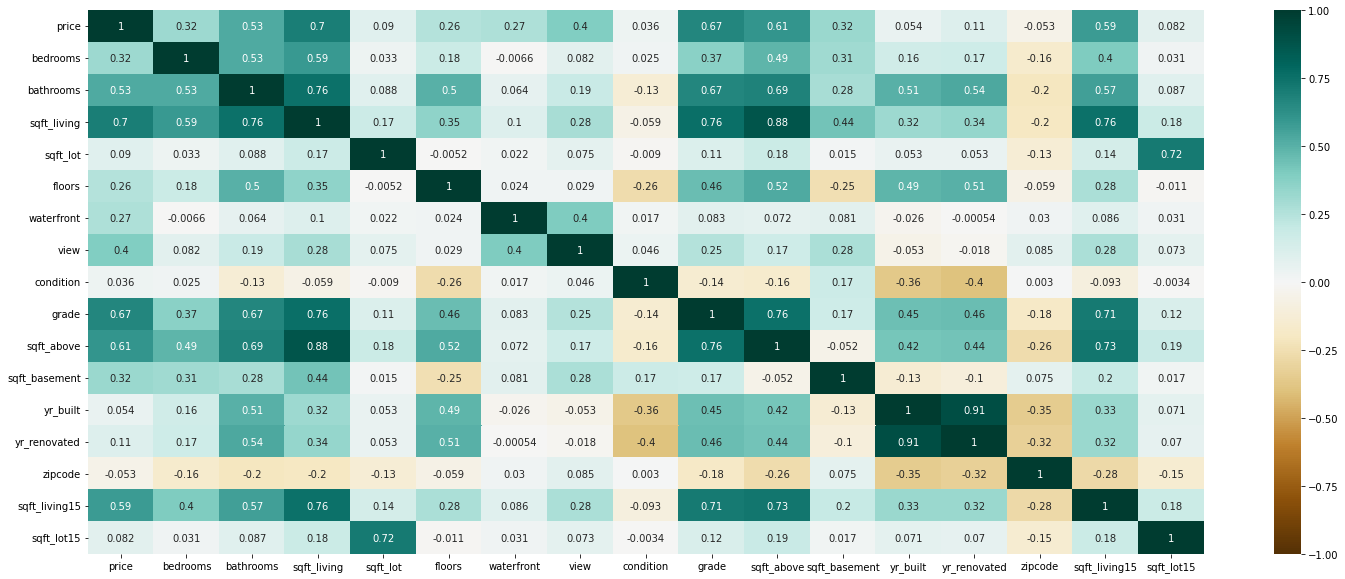

In [886]:
plt.figure(figsize=(25,10))
heatmap = sns.heatmap(kc.corr(),vmin=-1, vmax=1, annot=True, cmap = 'BrBG')

# Feature Engineering

* Renovated - True / False
* Has a basement
* Bedrooms / bathrooms ratio
* ratio of sqft living to sqft living15

Renovated

In [887]:
kc['Renovated'] = kc.yr_renovated - kc.yr_built

In [888]:
kc['Renovated'] = kc['Renovated'].apply(lambda x: 0 if x == 0 else 1)

In [889]:
kc['Renovated'] = kc['Renovated'].astype(str)

Has a basement

In [890]:
kc['has_basement'] = kc['sqft_basement']
kc['has_basement'] = kc['has_basement'].apply(lambda x: 0 if x == 0 else 1)
kc['has_basement'] = kc['has_basement'].astype(str)

Square foot living to Square foot living of neighbors

In [891]:
kc['relative_sqft_living'] = kc.sqft_living - kc.sqft_living15

Ratio of Bedrooms to Bathrooms

In [892]:
kc['bed_to_bath'] = (kc.bedrooms +1) / (kc.bathrooms+1)

# Encoding

In [893]:
kc_encode = kc.copy()

Categorical values:
* bedrooms
* bathrooms
* floors
* views
* condition
* grade
* waterfront
* zipcode

In [894]:
kc_encode.bedrooms = kc_encode.bedrooms.astype('str')
kc_encode.bathrooms = kc_encode.bathrooms.astype('str')
kc_encode.floors = kc_encode.floors.astype('str')
kc_encode.view = kc_encode.view.astype('str')
kc_encode.condition = kc_encode.condition.astype('str')
kc_encode.grade = kc_encode.grade.astype('str')
kc_encode.waterfront = kc_encode.waterfront.astype('str')
kc_encode.zipcode = kc_encode.zipcode.astype('str')

In [895]:
kc_encode.corr()['price'].sort_values(ascending=False)

price                   1.00000
sqft_living             0.70204
sqft_above              0.60557
sqft_living15           0.58538
relative_sqft_living    0.40539
sqft_basement           0.32382
yr_renovated            0.10575
sqft_lot                0.08966
sqft_lot15              0.08245
yr_built                0.05401
bed_to_bath            -0.23197
Name: price, dtype: float64

In [896]:
kc_encode.keys()

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'sqft_living15',
       'sqft_lot15', 'Renovated', 'has_basement', 'relative_sqft_living',
       'bed_to_bath'],
      dtype='object')

## Dummy encoding

In [897]:
kc_encode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  21613 non-null  datetime64[ns]
 1   price                 21613 non-null  float64       
 2   bedrooms              21613 non-null  object        
 3   bathrooms             21613 non-null  object        
 4   sqft_living           21613 non-null  int64         
 5   sqft_lot              21613 non-null  int64         
 6   floors                21613 non-null  object        
 7   waterfront            21613 non-null  object        
 8   view                  21613 non-null  object        
 9   condition             21613 non-null  object        
 10  grade                 21613 non-null  object        
 11  sqft_above            21613 non-null  int64         
 12  sqft_basement         21613 non-null  int64         
 13  yr_built        

In [898]:
kc_encode_dummies = kc_encode.copy()

In [899]:
kc_dummies = pd.get_dummies(kc_encode_dummies, columns = ['bedrooms', 'bathrooms', 'floors', 'view', 'condition', 'grade', 'zipcode'])

In [900]:
kc_dummies

,date,price,sqft_living,sqft_lot,waterfront,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,2014-10-13,221900.00000,1180,5650,0,1180,0,1955,1955,1340,...,0,0,0,0,0,0,1,0,0,0
1,2014-12-09,538000.00000,2570,7242,0,2170,400,1951,1991,1690,...,0,0,0,0,0,0,0,0,0,0
2,2015-02-25,180000.00000,770,10000,0,770,0,1933,1933,2720,...,0,0,0,0,0,0,0,0,0,0
3,2014-12-09,604000.00000,1960,5000,0,1050,910,1965,1965,1360,...,0,0,0,0,0,0,0,0,0,0
4,2015-02-18,510000.00000,1680,8080,0,1680,0,1987,1987,1800,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,2014-05-21,360000.00000,1530,1131,0,1530,0,2009,2009,1530,...,0,0,0,0,0,0,0,0,0,0
21609,2015-02-23,400000.00000,2310,5813,0,2310,0,2014,2014,1830,...,1,0,0,0,0,0,0,0,0,0
21610,2014-06-23,402101.00000,1020,1350,0,1020,0,2009,2009,1020,...,0,0,0,0,0,0,0,0,0,0
21611,2015-01-16,400000.00000,1600,2388,0,1600,0,2004,2004,1410,...,0,0,0,0,0,0,0,0,0,0


# Transformations

Features that need transforming and scaling
* sqft living
* sqft lot
* sqft above
* sqft basement (has zero values)
* year built
* year renovated
* lat
* long
* sqft_living15
* sqft_lot15

Features that have been encoded: 
* bedrooms
* bathrooms
* floors
* views
* condition
* grade
* waterfront
* zipcode

In [901]:
kc_dummies.keys()

Index(['date', 'price', 'sqft_living', 'sqft_lot', 'waterfront', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
       ...
       'zipcode_98146', 'zipcode_98148', 'zipcode_98155', 'zipcode_98166',
       'zipcode_98168', 'zipcode_98177', 'zipcode_98178', 'zipcode_98188',
       'zipcode_98198', 'zipcode_98199'],
      dtype='object', length=155)

In [902]:
hist_scale = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15', 'relative_sqft_living', 'bed_to_bath']

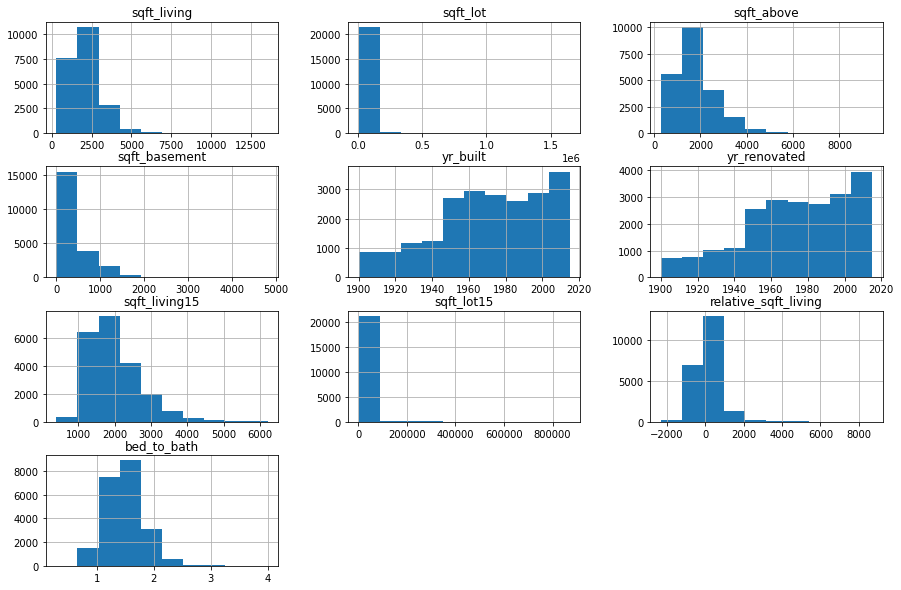

In [903]:
kc_dummies.hist(column = hist_scale, figsize = (15,10));

In [904]:
print('sqft_living skew: ' + str(kc_dummies.sqft_living.skew()))
print('sqft_lot skew: ' + str(kc_dummies.sqft_lot.skew()))
print('sqft_above skew: ' + str(kc_dummies.sqft_above.skew()))
print('sqft_basement skew: ' + str(kc_dummies.sqft_basement.skew()))
print('yr_built skew: ' + str(kc_dummies.yr_built.skew()))
print('yr_renovated skew: ' + str(kc_dummies.yr_renovated.skew()))
print('sqft_living15 skew: ' + str(kc_dummies.sqft_living15.skew()))
print('sqft_lot15 skew: ' + str(kc_dummies.sqft_lot15.skew()))
print('relative_sqft skew: ' + str(kc_dummies.relative_sqft_living.skew()))
print('bed_to_bath skew: ' + str(kc_dummies.bed_to_bath.skew()))

sqft_living skew: 1.471555426802092
sqft_lot skew: 13.060018959031755
sqft_above skew: 1.4466644733818372
sqft_basement skew: 1.5779650555996247
yr_built skew: -0.46980539881436767
yr_renovated skew: -0.5564821591712599
sqft_living15 skew: 1.1081812758966967
sqft_lot15 skew: 9.506743246764398
relative_sqft skew: 1.7262703868806324
bed_to_bath skew: 0.9923512955786582


Transform everything *except* yrs built and renovated

In [905]:
# sqft living is YJ
kc_dummies['sqft_living'] = list(stats.yeojohnson(kc_dummies['sqft_living'])[0])

# sqft lot is yj
kc_dummies['sqft_lot'] = list(stats.yeojohnson(kc_dummies['sqft_lot'])[0])

# sqft above is boxcox
kc_dummies['sqft_above'] = list(stats.boxcox(kc_dummies['sqft_above'])[0])

# sqft basement needs something for zero values
kc_dummies['sqft_basement'] = list(stats.yeojohnson(kc_dummies['sqft_basement'])[0])

# sqft living 15 is boxcox
kc_dummies['sqft_living15'] = list(stats.boxcox(kc_dummies['sqft_living15'])[0])

# sqft lot 15 is boxcox
kc_dummies['sqft_lot15'] = list(stats.boxcox(kc_dummies['sqft_lot15'])[0])

# relative sqft has zero values
kc_dummies['relative_sqft_living'] = list(stats.yeojohnson(kc_dummies['relative_sqft_living'])[0])

# bed to bath is boxcox
kc_dummies['bed_to_bath'] = list(stats.boxcox(kc_dummies['bed_to_bath'])[0])

In [906]:
# sqft_living_trans = np.log(kc.sqft_living)
# sqft_living_trans.hist()
# ##log transformation looks good, lock this in
# kc_dummies['sqft_living'] = sqft_living_trans
# kc_dummies['sqft_living'].hist()
# sqft_lot_trans = list(stats.boxcox(kc.sqft_lot)[0])
# plt.hist(sqft_lot_trans);
# ## BoxCox looks the best, lock this in
# kc_dummies['sqft_lot'] = sqft_lot_trans
# kc_dummies['sqft_lot'].hist()
# sqft_above_trans = np.log(kc.sqft_above)
# sqft_above_trans.hist()
# ##log looks good, lock it 
# kc_dummies['sqft_above'] = sqft_above_trans
# kc_dummies['sqft_above'].hist()
# sqft_basement_trans = np.sqrt(kc.sqft_basement)
# plt.hist(sqft_basement_trans)
# ##square root gets locked in
# kc_dummies['sqft_basement'] = sqft_basement_trans
# yr_built_trans = list(stats.boxcox(kc.yr_built)[0])
# plt.hist(yr_built_trans)
# ##go with boxcox
# kc_dummies['yr_built'] = yr_built_trans
# yr_renovated_trans = list(stats.boxcox(kc.yr_renovated)[0])
# plt.hist(yr_renovated_trans)
# ##go with boxcox
# kc_dummies['yr_renovated'] = yr_renovated_trans
# sqft_living15_trans = np.log(kc.sqft_living15)
# sqft_living15_trans.hist()
# ##go with log
# kc_dummies['sqft_living15'] = sqft_living15_trans
# sqft_lot15_trans = np.log(kc.sqft_lot15)
# sqft_lot15_trans.hist()
# ##go with log
# kc_dummies['sqft_lot15'] = sqft_lot15_trans

In [907]:
kc_dummies.describe()

,price,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,relative_sqft_living,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
count,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,...,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000
mean,540088.14177,8.40698,4.25184,3.53252,1.37731,1971.00514,1973.38602,3.55918,4.08998,-4.82025,...,0.01333,0.00264,0.02064,0.01175,0.01245,0.01180,0.01212,0.00629,0.01296,0.01467
std,367127.19648,0.52391,0.15255,0.07650,1.71645,29.37341,28.80685,0.05677,0.12447,556.60886,...,0.11467,0.05129,0.14216,0.10777,0.11087,0.10798,0.10943,0.07908,0.11308,0.12022
min,75000.00000,6.14626,3.63067,3.15449,-0.00000,1900.00000,1900.00000,3.23665,3.58499,-3167.94013,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,321950.00000,8.05125,4.17947,3.47784,0.00000,1951.00000,1954.00000,3.51969,4.02981,-270.65658,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,450000.00000,8.40941,4.25596,3.52864,0.00000,1975.00000,1977.00000,3.55751,4.09676,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,645000.00000,8.76738,4.31426,3.58947,3.49002,1997.00000,1999.00000,3.59981,4.14029,248.54206,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
max,7700000.00000,10.89339,4.85103,3.79583,3.94368,2015.00000,2015.00000,3.74288,4.58164,5970.31754,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


# Scaling

In [981]:
kc_dummies_scaled = kc_dummies.copy()

## Standard scaler

In [982]:
# standard_scaler = StandardScaler().fit(kc_dummies_scaled[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15']])
# kc_dummies_scaled[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15']] = standard_scaler.transform(kc_dummies_scaled[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15']])
# kc_dummies_scaled

## MinMax scaler

In [983]:
# minmax_scaler = MinMaxScaler().fit(kc_dummies_scaled[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15']])
# kc_dummies_scaled[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15']] = minmax_scaler.transform(kc_dummies_scaled[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15']])
# kc_dummies_scaled

## MaxAbs scaler

In [984]:
# maxabs_scaler = MaxAbsScaler().fit(kc_dummies_scaled[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15']])
# kc_dummies_scaled[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', sqft_living15', 'sqft_lot15']] = maxabs_scaler.transform(kc_dummies_scaled[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15']])
# kc_dummies_scaled

## Robust scaler

In [985]:
robust_scaler = RobustScaler().fit(kc_dummies_scaled[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15']])
kc_dummies_scaled[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15']] = robust_scaler.transform(kc_dummies_scaled[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15']])
kc_dummies_scaled

,date,price,sqft_living,sqft_lot,waterfront,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,2014-10-13,221900.00000,-0.82395,-0.40597,0,-0.46970,-0.00000,-0.43478,-0.48889,-0.71831,...,0,0,0,0,0,0,1,0,0,0
1,2014-12-09,538000.00000,0.51344,-0.06712,0,0.51745,0.97383,-0.52174,0.31111,-0.18748,...,0,0,0,0,0,0,0,0,0,0
2,2015-02-25,180000.00000,-1.54484,0.34976,0,-1.24936,-0.00000,-0.91304,-0.97778,0.81573,...,0,0,0,0,0,0,0,0,0,0
3,2014-12-09,604000.00000,0.04453,-0.57886,0,-0.67528,1.03465,-0.21739,-0.26667,-0.68356,...,0,0,0,0,0,0,0,0,0,0
4,2015-02-18,510000.00000,-0.22063,0.07726,0,0.11966,-0.00000,0.26087,0.22222,-0.04810,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,2014-05-21,360000.00000,-0.38094,-3.04231,0,-0.03170,-0.00000,0.73913,0.71111,-0.41150,...,0,0,0,0,0,0,0,0,0,0
21609,2015-02-23,400000.00000,0.32844,-0.36632,0,0.61109,-0.00000,0.84783,0.82222,-0.01190,...,1,0,0,0,0,0,0,0,0,0
21610,2014-06-23,402101.00000,-1.07102,-2.71066,0,-0.72720,-0.00000,0.73913,0.71111,-1.38016,...,0,0,0,0,0,0,0,0,0,0
21611,2015-01-16,400000.00000,-0.30431,-1.71565,0,0.04111,-0.00000,0.63043,0.60000,-0.59937,...,0,0,0,0,0,0,0,0,0,0


# Multiple Regression

## Transform the target feature

In [986]:
kc_dummies_scaled.price.skew()

4.024069144684712

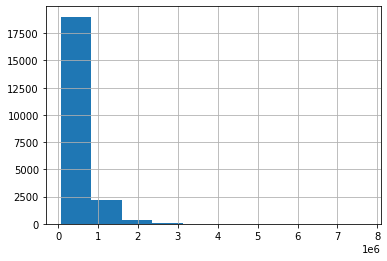

In [987]:
kc_dummies_scaled.price.hist()

In [988]:
print(np.log(kc_dummies_scaled.price).skew())
print(np.sqrt(kc_dummies_scaled.price).skew())
print((1/kc_dummies_scaled.price).skew())
print(pd.DataFrame(list(stats.boxcox(kc_dummies_scaled.price))[0]).skew()[0])

0.42807247557592526
1.6563918007900367
1.5044481177640696
-0.012280778296081447


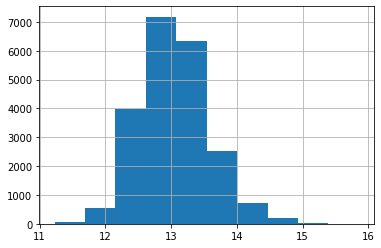

In [989]:
np.log1p(kc_dummies_scaled.price).hist()

In [990]:
kc_dummies_scaled['price'] = np.log1p(kc_dummies_scaled.price)

In [991]:
# pd.DataFrame(list(stats.boxcox(kc_dummies_scaled.price)[0])).hist()

In [992]:
# kc_dummies_scaled['price'] = pd.DataFrame(list(stats.boxcox(kc_dummies_scaled.price)[0]))

## Splitting up the data

In [993]:
kc_dummies_scaled.keys()

Index(['date', 'price', 'sqft_living', 'sqft_lot', 'waterfront', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
       ...
       'zipcode_98146', 'zipcode_98148', 'zipcode_98155', 'zipcode_98166',
       'zipcode_98168', 'zipcode_98177', 'zipcode_98178', 'zipcode_98188',
       'zipcode_98198', 'zipcode_98199'],
      dtype='object', length=155)

In [994]:
kc_dummies_scaled.drop(['date'], axis=1, inplace=True)

In [995]:
kc_dummies_scaled.keys()

Index(['price', 'sqft_living', 'sqft_lot', 'waterfront', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
       'sqft_lot15',
       ...
       'zipcode_98146', 'zipcode_98148', 'zipcode_98155', 'zipcode_98166',
       'zipcode_98168', 'zipcode_98177', 'zipcode_98178', 'zipcode_98188',
       'zipcode_98198', 'zipcode_98199'],
      dtype='object', length=154)

In [996]:
xtrain, xtest, ytrain, ytest = train_test_split(kc_dummies_scaled.loc[:, kc_dummies_scaled.columns != 'price'], kc_dummies_scaled.price, test_size = .3, random_state = 7)

In [997]:
xtrain.head()

,sqft_living,sqft_lot,waterfront,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,Renovated,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
20204,0.86686,0.30002,0,1.05519,-0.00000,0.84783,0.82222,1.00888,0.56852,0,...,0,0,0,0,0,0,0,0,1,0
15604,0.80015,0.52770,0,1.00208,-0.00000,-0.08696,0.75556,0.51040,0.45695,1,...,1,0,0,0,0,0,0,0,0,0
2163,-0.46106,-3.23924,0,-0.51458,0.95275,0.67391,0.64444,-0.51878,-3.17639,0,...,0,0,0,0,0,0,0,0,0,0
6338,0.07937,-2.05670,0,0.39321,-0.00000,0.65217,0.62222,-0.36736,-3.02319,0,...,0,0,0,0,0,0,0,0,0,0
19379,0.03571,-1.56584,0,-0.37023,1.01637,-1.41304,-1.48889,-0.42645,-2.87830,0,...,0,0,0,0,0,0,0,0,0,0


In [998]:
ytrain.describe()

count   15129.00000
mean       13.04801
std         0.52923
min        11.22526
25%        12.67920
50%        13.01701
75%        13.38319
max        15.85673
Name: price, dtype: float64

In [999]:
xtest.head()

,sqft_living,sqft_lot,waterfront,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,Renovated,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
18732,-0.72595,0.41410,0,-0.37023,-0.00000,-0.19565,-0.24444,-0.36736,0.10367,0,...,0,0,0,0,0,0,0,0,0,0
18573,0.57327,0.45993,0,0.25522,1.02835,0.28261,0.24444,0.87333,0.38617,0,...,0,0,0,0,0,0,0,0,0,0
11401,0.45155,-0.90522,0,-0.38402,1.05497,-0.58696,0.82222,0.60474,-0.99753,1,...,0,0,0,0,0,0,0,0,0,0
19712,-0.32154,-1.24593,0,0.02482,-0.00000,0.78261,0.75556,-0.33279,-1.60896,0,...,0,0,0,0,0,0,0,0,0,0
17921,0.41621,-1.22226,0,0.68595,-0.00000,0.76087,0.73333,0.76359,-1.06353,0,...,0,0,0,0,0,0,0,0,0,0


In [1000]:
ytest

18732   13.04332
18573   13.55155
11401   13.73213
19712   12.47991
17921   12.96571
          ...   
8169    13.35348
11010   13.16542
739     12.35880
7840    12.70077
10937   12.51356
Name: price, Length: 6484, dtype: float64

## Training the model and running the predictions

### Linear Regression

In [1043]:
kc_regress = LinearRegression().fit(xtrain, ytrain)
kc_regress.score(xtest, ytest)

0.8829826867392889

In [1044]:
ypred = kc_regress.predict(xtest)
ypred

array([12.95513136, 13.4880214 , 13.52828679, ..., 12.35061177,
       12.77952647, 12.54858333])

#### Analyzing the results

Mean Square Error: 17,615,391,161.69
Root Mean Square Error: 132,722.99
Mean Absolute Error: 72,185.46


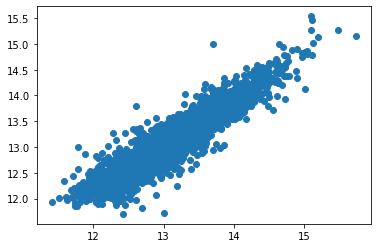

In [1045]:
mse = mean_squared_error(np.expm1(ytest), np.expm1(ypred))
rmse = np.sqrt(mse)
mae = mean_absolute_error(np.expm1(ytest), np.expm1(ypred))

print('Mean Square Error: ' + str("{:,.2f}".format(mse)))
print('Root Mean Square Error: ' + str("{:,.2f}".format(rmse)))
print('Mean Absolute Error: ' + str("{:,.2f}".format(mae)))
plt.scatter(ytest,ypred)

### Lasso Regression

In [1097]:
kc_lasso = Lasso(alpha = 0.000005).fit(xtrain, ytrain)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.227e+02, tolerance: 4.237e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [1098]:
ypred = kc_lasso.predict(xtest)
ypred

array([12.9646072 , 13.49126655, 13.5254413 , ..., 12.35024894,
       12.77829735, 12.54849052])

#### Lasso - Analyzing the results

Mean Square Error: 15,970,195,735.48
Root Mean Square Error: 126,373.24
Mean Absolute Error: 71,730.53


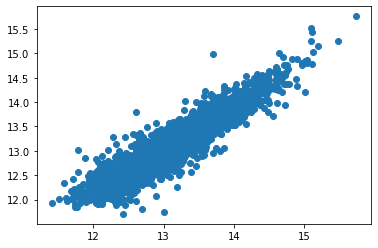

In [1099]:
mse = mean_squared_error(np.expm1(ytest), np.expm1(ypred))
rmse = np.sqrt(mse)
mae = mean_absolute_error(np.expm1(ytest), np.expm1(ypred))

print('Mean Square Error: ' + str("{:,.2f}".format(mse)))
print('Root Mean Square Error: ' + str("{:,.2f}".format(rmse)))
print('Mean Absolute Error: ' + str("{:,.2f}".format(mae)))
plt.scatter(ytest,ypred)

### Ridge Regression

In [1112]:
kc_ridge = Ridge(alpha = 0.005).fit(xtrain, ytrain)

In [1113]:
ypred = kc_ridge.predict(xtest)
ypred

array([12.95653824, 13.48818477, 13.52802268, ..., 12.35049021,
       12.77923645, 12.548464  ])

#### Analyzing the results

Mean Square Error: 17,292,191,668.29
Root Mean Square Error: 131,499.78
Mean Absolute Error: 72,128.67


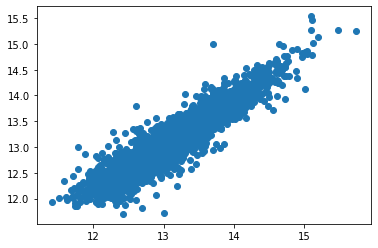

In [1114]:
mse = mean_squared_error(np.expm1(ytest), np.expm1(ypred))
rmse = np.sqrt(mse)
mae = mean_absolute_error(np.expm1(ytest), np.expm1(ypred))

print('Mean Square Error: ' + str("{:,.2f}".format(mse)))
print('Root Mean Square Error: ' + str("{:,.2f}".format(rmse)))
print('Mean Absolute Error: ' + str("{:,.2f}".format(mae)))
plt.scatter(ytest,ypred)